In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
from tqdm.auto import tqdm
from time_series import create_time_series
sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))
import fsrs_optimizer
import numpy as np

tqdm.pandas()

In [2]:
# Review count: User id
# Median: 8798
# Most: 6810

USER_ID = 4323
df = pd.read_parquet(
    "../anki-revlogs-10k/revlogs", filters=[("user_id", "=", USER_ID), ("rating", "in", [1, 2, 3, 4])], columns=["card_id", "day_offset", "rating", "elapsed_days", "duration"] 
)
df.size

192860

In [3]:
df.describe()

,card_id,day_offset,rating,elapsed_days,duration
count,38572.000000,38572.000000,38572.000000,38572.000000,38572.000000
mean,5443.914342,140.594913,2.283496,2.243104,11099.716686
std,2651.458536,173.252201,1.070957,18.473117,10870.284962
min,0.000000,0.000000,1.000000,-1.000000,0.000000
25%,3392.000000,57.000000,1.000000,-1.000000,4922.000000
50%,4954.500000,102.000000,3.000000,0.000000,7795.000000
75%,7231.000000,162.000000,3.000000,1.000000,12794.000000
max,11153.000000,955.000000,4.000000,551.000000,100000.000000


In [5]:
df["last_duration"] = df.groupby("card_id")["duration"].shift(1, fill_value=-1)

In [6]:
print("creating time series")
df["delta_t"] = df["elapsed_days"]
df: pd.DataFrame = create_time_series(df)
print("training")
trainer = fsrs_optimizer.Trainer(df, df, fsrs_optimizer.DEFAULT_PARAMETER)
w = trainer.train()

creating time series
training


train:   0%|          | 0/16811 [00:00<?, ?it/s]

iteration: 1536
w: [0.3585, 1.1648, 3.1588, 15.7374, 7.2223, 0.5385, 1.4564, 0.0177, 1.5254, 0.0981, 0.999, 1.8996, 0.1495, 0.2549, 2.231, 0.2233, 2.979, 0.469, 0.6271]
iteration: 3072
w: [0.3201, 1.1502, 3.1322, 15.7769, 7.2313, 0.5349, 1.459, 0.0251, 1.5308, 0.0789, 1.003, 1.8863, 0.1627, 0.2416, 2.2187, 0.2326, 2.9784, 0.4504, 0.6027]
iteration: 4608
w: [0.2979, 1.142, 3.1136, 15.8018, 7.2326, 0.5321, 1.446, 0.0427, 1.5368, 0.0892, 1.0099, 1.8821, 0.1659, 0.2372, 2.2272, 0.2543, 2.9919, 0.4361, 0.5935]
iteration: 6144
w: [0.2629, 1.138, 3.0984, 15.8169, 7.26, 0.5084, 1.462, 0.0296, 1.5085, 0.0759, 0.9821, 1.8742, 0.1742, 0.229, 2.2171, 0.2403, 2.9733, 0.446, 0.5776]
iteration: 7680
w: [0.2391, 1.1348, 3.0883, 15.8191, 7.28, 0.4926, 1.4791, 0.0109, 1.4873, 0.0656, 0.9611, 1.8704, 0.1779, 0.2249, 2.2143, 0.2356, 2.956, 0.4512, 0.5704]
iteration: 9216
w: [0.2226, 1.1316, 3.0672, 15.8169, 7.2958, 0.4812, 1.4864, 0.0075, 1.4725, 0.058, 0.9466, 1.865, 0.183, 0.2188, 2.2145, 0.2318, 2.9477

In [7]:
import math

DECAY = -0.5
FACTOR = 0.9 ** (1 / DECAY) - 1

def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY

def stability_after_success(s, r, d, rating):
    hard_penalty = w[15] if rating == 2 else 1
    easy_bonus = w[16] if rating == 4 else 1
    return max(
        0.01,
        s * (
            1
            + math.exp(w[8])
            * (11 - d)
            * (s ** -w[9])
            * (math.exp((1 - r) * w[10]) - 1)
            * hard_penalty
            * easy_bonus
        )
    )

def stability_after_failure(s, r, d):
    return max(
        0.01,
        min(
            w[11]
            * (d ** -w[12])
            * ((s + 1) ** w[13] - 1)
            * math.exp((1 - r) * w[14]),
            s / math.exp(w[17] * w[18])
        )
    )

def stability_short_term(s, init_rating=None):
    if init_rating is not None:
        rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[init_rating - 1]
        session_len = fsrs_optimizer.DEFAULT_FIRST_SESSION_LENS[init_rating - 1]
    else:
        rating_offset = fsrs_optimizer.DEFAULT_FORGET_RATING_OFFSET
        session_len = fsrs_optimizer.DEFAULT_FORGET_SESSION_LEN
    
    new_s = s * math.exp(
        w[17] * (rating_offset + session_len * w[18])
    )
    return new_s

def init_d(rating):
    return w[4] - math.exp(w[5] * (rating - 1)) + 1

def init_d_with_short_term(rating):
    rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[rating - 1]
    new_d = init_d(rating) - w[6] * rating_offset
    return max(1, min(new_d, 10))

def linear_damping(delta_d, old_d):
    return delta_d * (10 - old_d) / 9

def mean_reversion(init, current):
    return w[7] * init + (1 - w[7]) * current

def next_d(d, rating):
    delta_d = -w[6] * (rating - 3)
    new_d = d + linear_damping(delta_d, d)
    new_d = mean_reversion(init_d(4), new_d)
    return max(1, min(new_d, 10))


In [9]:
def memory_state(df):
    t_history = [int(t) for t in df["t_history"].split(",")]
    r_history = [int(r) for r in df["r_history"].split(",")]
    difficulty = None
    stability = None
    retrievability = 1e-10
    for delta_t, rating in zip(t_history, r_history):
        if stability is None:  # New card
            difficulty = init_d_with_short_term(rating)
            stability = stability_short_term(w[rating - 1], init_rating=rating)
        else:
            retrievability = power_forgetting_curve(delta_t, stability)
            if rating > 1:
                stability = stability_after_success(
                    stability, retrievability, difficulty, rating
                )
            else:
                stability = stability_after_failure(stability, retrievability, difficulty)
                stability = stability_short_term(stability)
            difficulty = next_d(difficulty, rating)
            if rating == 1:
                difficulty -= (w[6] * fsrs_optimizer.DEFAULT_FORGET_RATING_OFFSET)
                difficulty = min(max(difficulty, 1), 10)

    return stability, difficulty, retrievability


df["s"], df["d"], df["r"] = zip(*df.progress_apply(memory_state, axis=1))

  0%|          | 0/16811 [00:00<?, ?it/s]

In [10]:
df["loss"] = df.apply(lambda df: (df["y"] - df["r"]) ** 2, axis=1)
df["duration"] = (df["duration"] / 1000).round(0)

Average Very Young cards per day 1.4748677248677249


<Figure size 640x480 with 0 Axes>

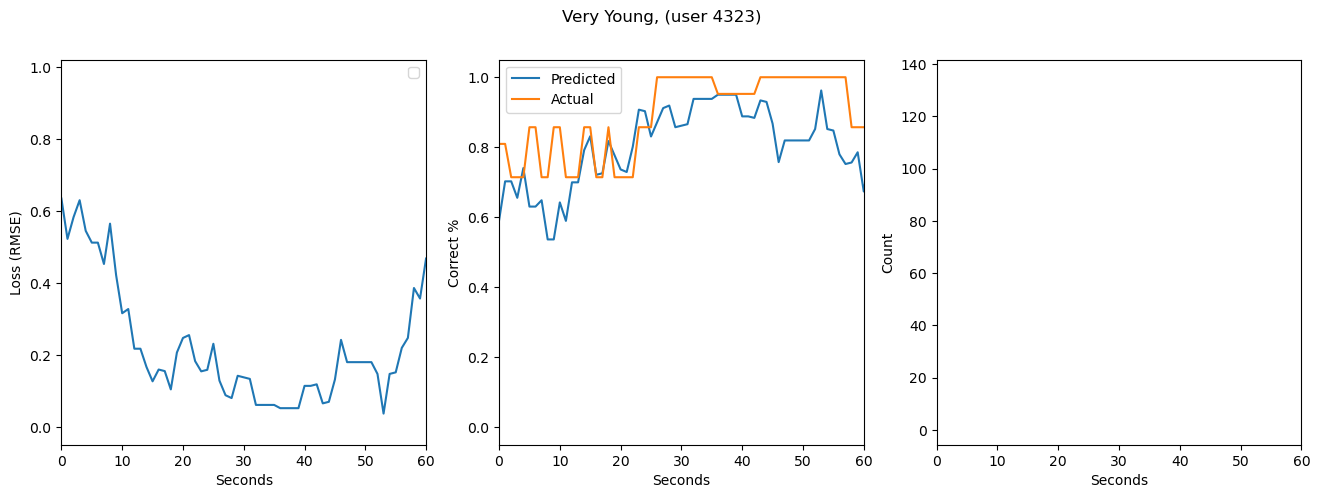

Average Young cards per day 1.5490335586386814


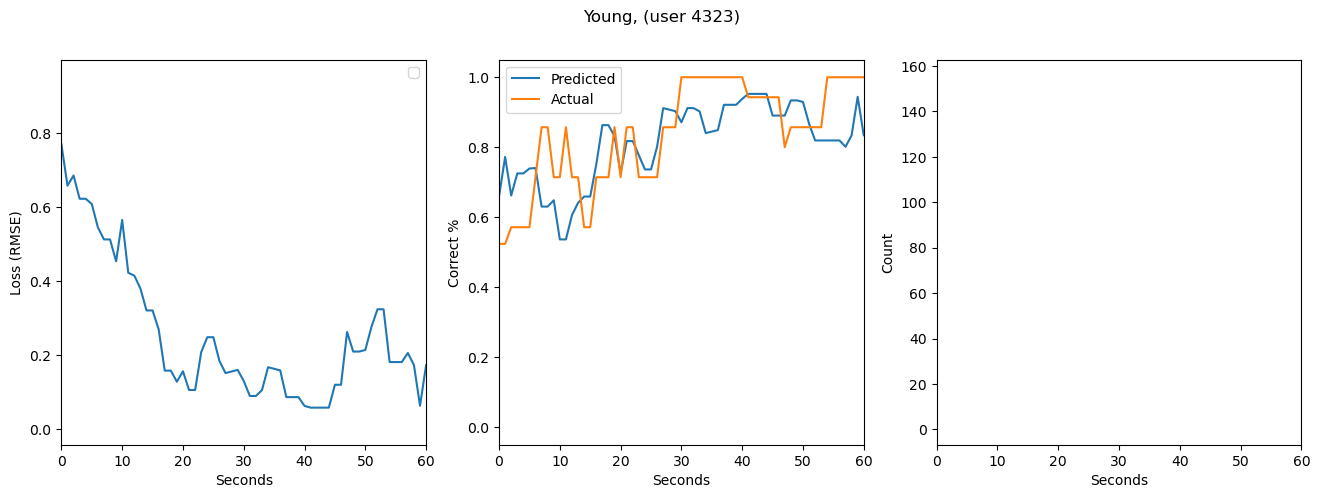

Average Mature cards per day 1.0611620795107033


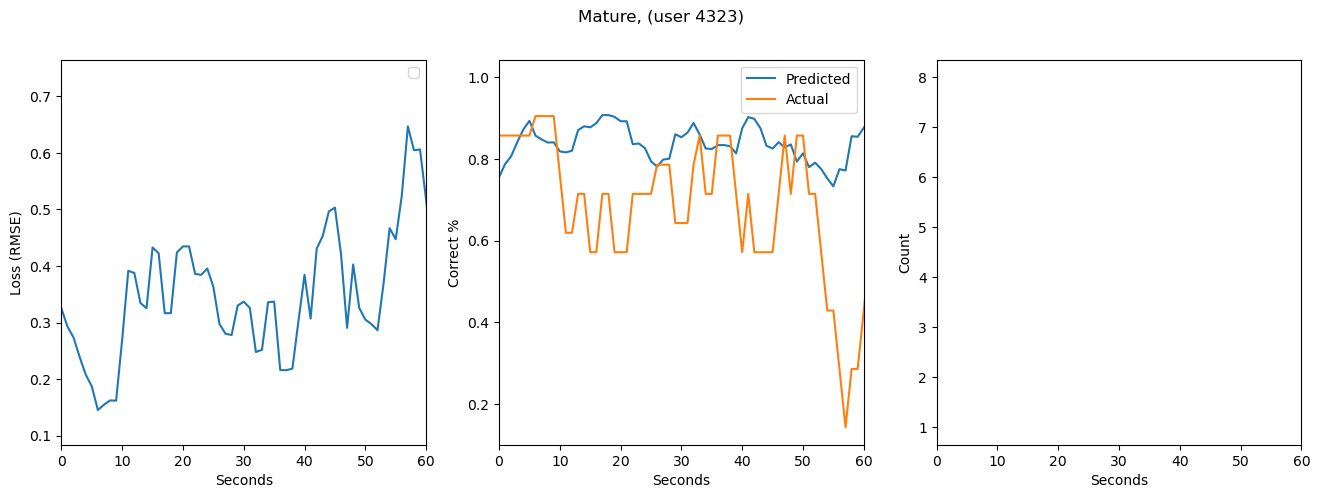

Average All cards per day 1.5643957069528698


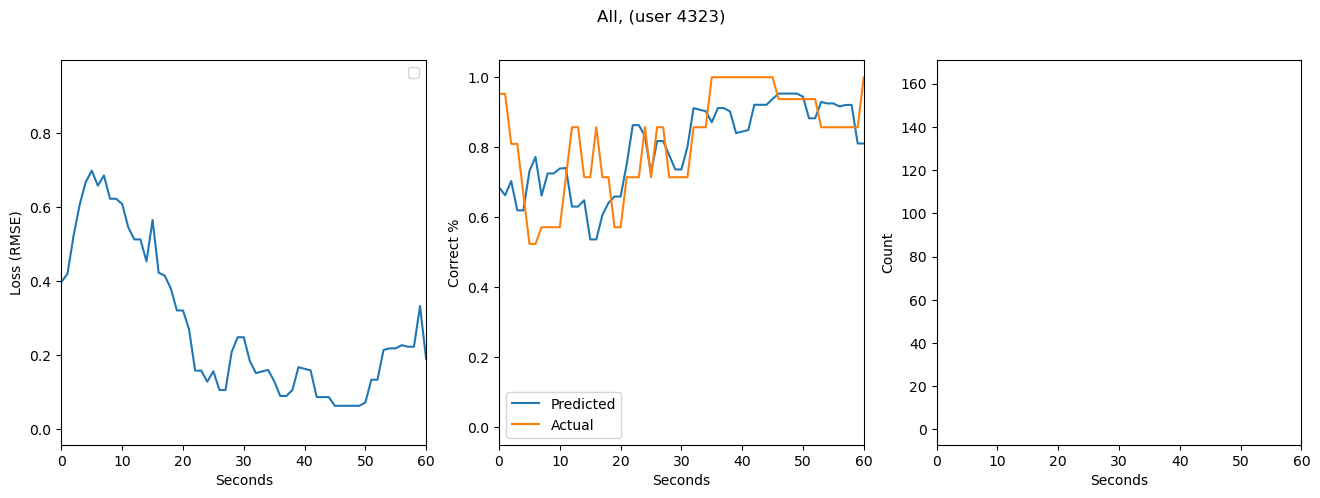

In [11]:
plt.clf()
categories = [
    #("Learn", -1, 1), 
    ("Very Young", 0, 4), 
    ("Young", 0, 21), 
    ("Mature", 21, 1e20),
    ("All", -1, 1e20)
]

# https://stackoverflow.com/a/54628145/24162642
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for name, lower, upper in categories:
    df_filtered = df[(df["elapsed_days"] > lower) & (df["elapsed_days"] <= upper) & (df["r"] > 1e-9)].groupby("last_duration")

    print(f"Average {name} cards per day {df_filtered['card_id'].count().mean()}")
    loss = df_filtered["loss"].mean() ** 0.5
    loss = moving_average(loss, 7)

    fig = plt.figure(figsize=(16, 5))
    fig.suptitle(f"{name}, (user {USER_ID})")
    ax1 = fig.add_subplot(131)
    xlim = 60

    ax1.set_xlabel('Seconds')
    ax1.set_ylabel('Loss (RMSE)')
    ax1.plot(loss)
    ax1.legend()
    ax1.set_xlim(0, xlim)


    ax2 = fig.add_subplot(132)

    ax2.plot(moving_average(df_filtered["r"].mean(), 7), label="Predicted")
    ax2.plot(moving_average(df_filtered["y"].mean(), 7), label="Actual")
    ax2.set_xlabel('Seconds')
    ax2.set_ylabel('Correct %')
    ax2.set_xlim(0, xlim)
    ax2.legend()

    ax3 = fig.add_subplot(133)

    ax3.plot(df_filtered["r"].count())
    ax3.set_xlabel('Seconds')
    ax3.set_ylabel('Count') # Number of days that the user had that many reviews or more
    ax3.set_xlim(0, xlim)

    plt.show()
